In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import STL
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Load actual data from the Excel file
actual_data = pd.read_excel("DATAFORMODELtrain200824.xlsx")

# Convert 'Date' to datetime format
actual_data['Date'] = pd.to_datetime(actual_data['Date'], format='%m/%d/%Y %H:%M')



In [ ]:
# Filter the actual data to the specified date range
start_date = "2024-07-01 23:00"
end_date = "2024-08-20 23:00"
actual_data_filtered = actual_data[(actual_data['Date'] >= start_date) & (actual_data['Date'] <= end_date)]

# Load forecast data from the CSV file
forecast_data = pd.read_csv("forecast_output.csv")

# Convert 'ds' to datetime format
forecast_data['ds'] = pd.to_datetime(forecast_data['ds'])

# Filter the forecast data to the specified date range
forecast_data_filtered = forecast_data[(forecast_data['ds'] >= start_date) & (forecast_data['ds'] <= end_date)]


In [ ]:
# Merge actual and forecasted data on the date column
merged_data = pd.merge(actual_data_filtered[['Date', 'PriceSK']],
                       forecast_data_filtered[['ds', 'yhat']],
                       left_on='Date',
                       right_on='ds',
                       how='inner')

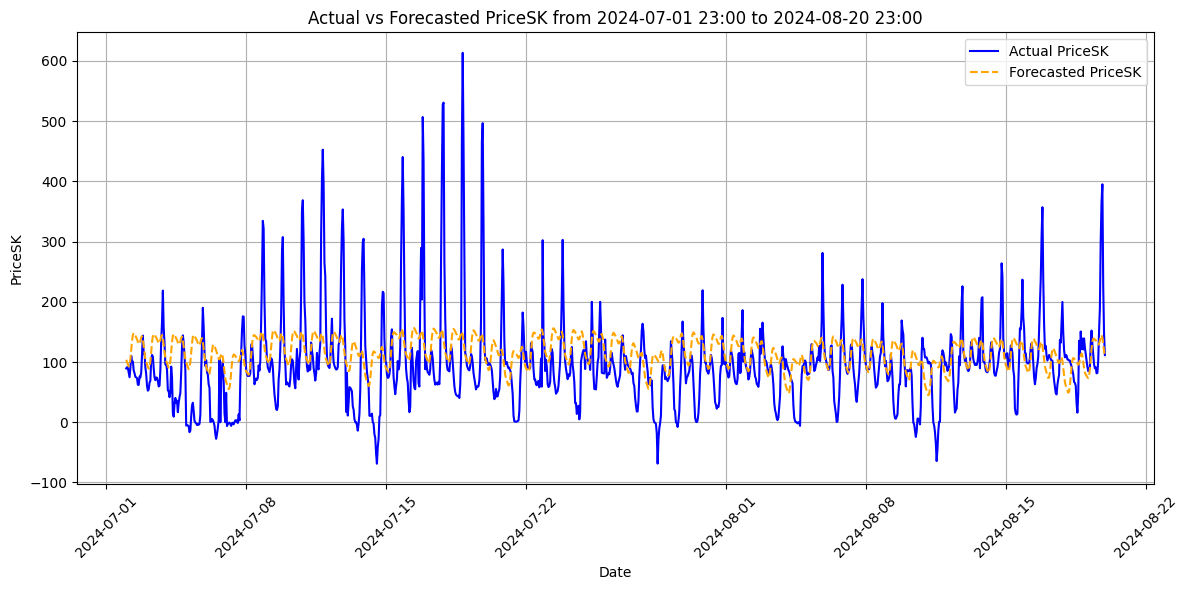

In [ ]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], merged_data['PriceSK'], label='Actual PriceSK', color='blue')
plt.plot(merged_data['Date'], merged_data['yhat'], label='Forecasted PriceSK', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('PriceSK')
plt.title('Actual vs Forecasted PriceSK from 2024-07-01 23:00 to 2024-08-20 23:00')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Engineering

In [ ]:
data = actual_data.copy()

In [ ]:
columns_to_drop = [
    'Y', 'M', 'Day', 'H', 'Y2016',	'Y2017',	'Y2018',	'Y2019',	'Y2020',	'Y2021',	'Y2022',	'Y2023',	'Y2024',
    'M1',	'M2',	'M3',	'M4',	'M5',	'M6',	'M7',	'M8',	'M9',	'M10',	'M11',	'M12',
    'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
    'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19',
    'h20', 'h21', 'h22', 'h23', 'h24'
]

In [ ]:
data = data.drop(columns=columns_to_drop)

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Get the correlations of all columns with 'PriceSK'
price_sk_correlation = correlation_matrix['PriceSK'].sort_values(ascending=False)

# Display the most relevant features that correlate with 'PriceSK'
print(price_sk_correlation)

PriceSK         1.000000
PriceHU         0.982545
PriceCZ         0.981075
GAS             0.885140
COAL            0.810247
CO2             0.612290
UNAVHYDRBG      0.565112
T2MALLPCO2      0.545252
UNAVGASBG       0.528106
UNAVHYDRALL     0.489056
UNAVGASALL      0.458272
Date            0.452247
UNAVGASSK       0.442859
UNAVTPPHU       0.429091
UNAVGASHU       0.417407
UNAVNUCFR       0.405772
UNAVTPPSK       0.371019
PriceRO         0.363070
SOLMAX          0.290895
UA_SK           0.239188
UNAVLIGNHU      0.224148
UNAVHYDRRO      0.179999
PL_SK           0.169328
UNAVTPPBG       0.163033
PMIHU           0.139165
WDAY            0.123028
UNAVHYDRFR      0.122945
HUSOLGEN        0.115321
UNAVGASCZ       0.108427
UNAVNUCHU       0.093346
T2MALLNONLIN    0.076990
RHSOLGEN        0.071225
T2MROPSQ        0.066608
T2MHUPSQ        0.066037
T2MROP          0.060558
T2MRO           0.060558
UADEM           0.056461
T2MSKPSQ        0.055825
T2MALLP         0.054306
T2MALL          0.054306


In [ ]:
# Handling Missing Values
data = data.interpolate(method='linear')  # Example of linear interpolation

# Feature Engineering
data['hour'] = data['Date'].dt.hour
data['day_of_week'] = data['Date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
data['month'] = data['Date'].dt.month
data['rolling_mean_7d'] = data['PriceSK'].rolling(window=7).mean()  # Example of rolling mean
data['lag_1'] = data['PriceSK'].shift(1)  # Example of lag feature

In [ ]:
# Mutual Information for Feature Selection
X = data.drop(['PriceSK', 'Date'], axis=1)
y = data['PriceSK']

# Ensure all columns are numeric or properly formatted for mutual_info_regression
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

mi = mutual_info_regression(X, y)
mi_scores = pd.Series(mi, name="MI Scores", index=X.columns).sort_values(ascending=False)


In [ ]:
print(mi_scores)

PriceCZ            6.276482
PriceHU            4.455378
PriceRO            2.534454
lag_1              1.920776
rolling_mean_7d    1.263799
GAS                0.991158
COAL               0.981401
UNAVGASRO          0.913110
CO2                0.864042
PMIHU              0.858779
COALTOGAS          0.832019
UNAVGASHU          0.798095
UNAVTPPRO          0.745359
UNAVGASALL         0.727211
UNAVTPPBG          0.720326
UNAVLIGNRO         0.709855
UNAVTPPHU          0.691973
UNAVHYDRALL        0.678235
SOLMAX             0.601145
UNAVLIGNBG         0.581801
UNAVHYDRBG         0.573764
UNAVNUCFR          0.534990
UA_HU              0.533783
UNAVTPPCZ          0.509389
UNAVNUCALL         0.507019
UA_EU              0.503441
UNAVLIGNALL        0.496210
UNAVLIGNCZ         0.488708
UNAVTPPSL          0.472295
UNAVLIGNSL         0.468683
T2MALLMAX          0.464554
T2MALLMIN          0.460594
UNAVHYDRFR         0.457758
T2MALLPCO2         0.453630
UNAVGASCZ          0.451007
RORDE_HP           0

In [ ]:
# Interaction Features
data['PriceCZ_GAS'] = data['PriceCZ'] * data['GAS']
data['COAL_CO2'] = data['COAL'] * data['CO2']

In [ ]:
# Polynomial Features for Selected Variables
poly = PolynomialFeatures(degree=2, include_bias=False)
selected_features = ['GAS', 'COAL', 'CO2', 'PriceCZ', 'PriceHU']
poly_features = poly.fit_transform(data[selected_features])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(selected_features))


In [ ]:
# Merge Polynomial Features back to the DataFrame
data = pd.concat([data, poly_df], axis=1)

In [ ]:
# Dimensionality Reduction using PCA for Less Significant Features
less_significant_features = ['UNAVTPPRO', 'UNAVGASALL', 'UNAVTPPBG', 'UNAVLIGNRO']
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data[less_significant_features])
pca_df = pd.DataFrame(pca_features, columns=[f'PCA_{i+1}' for i in range(2)])
data = pd.concat([data, pca_df], axis=1)

In [ ]:
# Feature Selection using LASSO
X = data.drop(['PriceSK', 'Date'], axis=1).fillna(0)
y = data['PriceSK']
lasso = LassoCV(cv=10, random_state=42)
lasso.fit(X, y)

LassoCV(cv=10, random_state=42)

In [ ]:
# Get selected features from LASSO
selected_features = X.columns[(lasso.coef_ != 0)]
print("Selected Features from LASSO:", selected_features)

Selected Features from LASSO: Index(['T2MALLPROR', 'UNAVNUCFR', 'DEWINDGEN', 'COAL_CO2', 'GAS PriceCZ',
       'COAL^2', 'COAL CO2', 'COAL PriceHU', 'CO2 PriceCZ', 'CO2 PriceHU',
       'PriceCZ^2', 'PriceHU^2'],
      dtype='object')


# Columns to Plot

In [ ]:
# Define the column names to plot
column1 = 'PriceCZ'  # Replace with the actual column name
column2 = 'PriceHU'  # Replace with the actual column name
column3 = 'PriceRO'  # Replace with the actual column name
column4 = 'ROSOLGEN'  # Replace with the actual column name
column5 = 'T2MALL'  # Replace with the actual column name
column6 = 'WS10MRO'  # Replace with the actual column name

# date range plotting

In [ ]:
# Define the date range for which you want to plot the data
start_date = '2018-01-01'  # Replace with the desired start date
end_date = '2018-02-01'  # Replace with the desired end date
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

In [ ]:
# Filter data for the specific date range
data_range = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Handle missing values in PriceSK and other columns
data_range['PriceSK'] = data_range['PriceSK'].interpolate(method='linear')
data_range['PriceSK'] = data_range['PriceSK'].bfill().ffill()  # Use bfill() and ffill() directly


In [ ]:
# Define the column names to plot
column1 = 'COAL'  # Replace with the actual column name
column2 = 'GAS'  # Replace with the actual column name
column3 = 'CO2'  # Replace with the actual column name
column4 = 'ROSOLGEN'  # Replace with the actual column name
column5 = 'T2MALL'  # Replace with the actual column name
column6 = 'WS10MRO'  # Replace with the actual column name

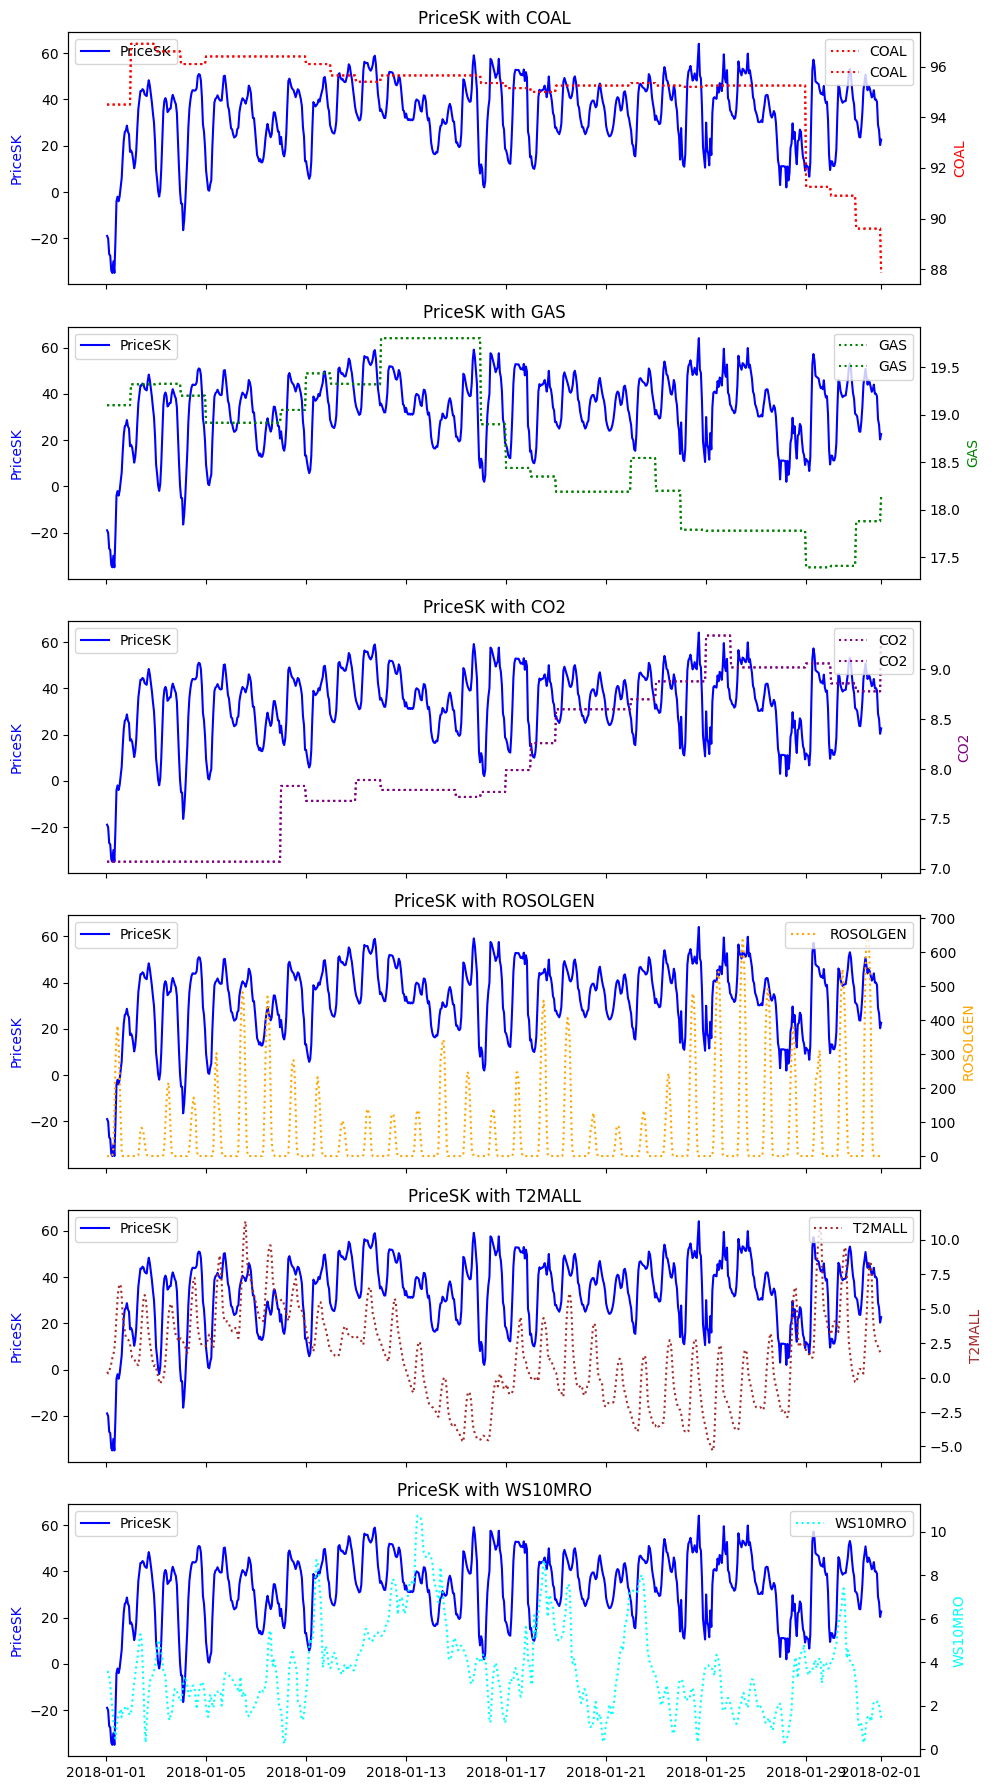

In [ ]:
# Initialize a figure with subplots
fig, axes = plt.subplots(6, 1, figsize=(10, 18), sharex=True)  # 6 separate subplots

# Plotting function to create subplots with secondary y-axes
def create_plot(ax, y1, y2, y1_label, y2_label, color1, color2):
    ax.plot(data_range['Date'], data_range[y1], label=y1_label, color=color1, linestyle='-')
    ax.set_ylabel(y1_label, color=color1)
    ax2 = ax.twinx()  # Create a secondary y-axis
    ax2.plot(data_range['Date'], data_range[y2], label=y2_label, color=color2, linestyle=':')
    ax2.set_ylabel(y2_label, color=color2)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.set_title(f'{y1_label} with {y2_label}')

# Create plots for each subplot
create_plot(axes[0], 'PriceSK', column1, 'PriceSK', column1, 'blue', 'red')
create_plot(axes[1], 'PriceSK', column2, 'PriceSK', column2, 'blue', 'green')
create_plot(axes[2], 'PriceSK', column3, 'PriceSK', column3, 'blue', 'purple')
create_plot(axes[3], 'PriceSK', column4, 'PriceSK', column4, 'blue', 'orange')
create_plot(axes[4], 'PriceSK', column5, 'PriceSK', column5, 'blue', 'brown')
create_plot(axes[5], 'PriceSK', column6, 'PriceSK', column6, 'blue', 'cyan')

# Formatting and display
plt.xlabel('Date and Hour')
plt.tight_layout()
plt.show()